# Genetic Algorithm for SNN, MultiThreaded

In [1]:
import numpy as np
import random
from random import randint
import operator
from array import *
import math
import time
import itertools
import sys 
import os

import pandas as pd
import matplotlib.pyplot as plt

# TODO:
[v] Make the Q-value the fitness function \
[v] MUTATION problem \
[v] Discuss about weights with ema -> Now are turned off \
[v] Clodveneto (?) \
[v] Use 10,000 events for the algorithm on the machines \
[v] //TODO: Ema check SNN -> Create a check and set for threshold automatically \
[v] Check for a lot of firings: If a combination of parameters takes a lot to be computed or kill it or save that parameters into a histogram and store them, change few parameters and let tne next generations see the stored ones, in order to avoid the same problem. (Or simpli increse the threshold)




In [49]:
import subprocess
import re

def run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_plus, a_minus, CFI0, CF01, CFI1, alpha, TH0, TH1):
    try:
        command = f'./SNNT13.out --N_ev {N_ev} --tau_m {tau_m} --tau_s {tau_s} --tau_plus {tau_plus} --tau_minus {tau_minus} --a_plus {a_plus} --a_minus {a_minus} --CFI0 {CFI0} --CF01 {CF01} --CFI1 {CFI1} --alpha {alpha} --TH0 {TH0} --TH1 {TH1}'
        
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        
        values = {
            'Eff': 0,
            'Fr': 0,
            'Q': 0,
            'Selectivity': 0,
        }

        for line in iter(process.stdout.readline, ''):
            line = line.strip()
            if 'Average efficiency:' in line:
                match = re.search(r'Average efficiency: (\d+\.\d+)', line)
                print("--------------------------", match, type(match))
                if match:
                    values['Eff'] = float(match.group(1))
                else:
                    values['Eff'] = 1
                    
            elif 'Average fake rate:' in line:
                match = re.search(r'Average fake rate: (\d+\.\d+)', line)
                if match:
                    values['Fr'] = float(match.group(1))
            elif 'Maximum Q value:' in line:
                match = re.search(r'Maximum Q value: (\d+\.\d+)', line)
                if match:
                    values['Q'] = float(match.group(1))
            elif 'L1 selectivity:' in line:
                match = re.search(r'L1 selectivity: (\d+\.\d+)', line)
                if match:
                    values['Selectivity']= float(match.group(1))
                print(line)  # Optionally, you can print the line as it comes
            
        process.communicate()  # Wait for the process to finish
        
        return values
    
    except Exception as e:
        print(f"Error during the execution of SNN: {e}")
        return None

output_values = run_SNN(
    N_ev=300, tau_m=1e-9/2, tau_s=0.25e-9/2, tau_plus=1.68e-9/2, tau_minus=3.37e-9/2, a_plus=0.00003125/10, a_minus=0.001, CFI0=1, CF01=1, CFI1=1, alpha=0.5, TH0=0.45, TH1=0.45,
)

if output_values:
    print(f'Average efficiency: {output_values["Eff"]}')
    print(f'Average fake rate: {output_values["Fr"]}')
    print(f'Maximum Q value: {output_values["Q"]}')
    print(f'Selectivity: {output_values["Selectivity"]}')


-------------------------- <re.Match object; span=(0, 28), match='Average efficiency: 0.513889'> <class 're.Match'>
L1 selectivity: 0.568004
Average efficiency: 0.513889
Average fake rate: 0
Maximum Q value: 4.12795
Selectivity: 0.568004


## Fitness Selectivity

## Fitness Efficiency - Fake

In [44]:
#select the minimum in between 2 values
def min2(a,b):
    if a < b:
        return a
    else:
        return b
    
def max2(a,b):
    if a > b:
        return a
    else:
        return b

In [45]:
#fitness function
def fitness(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1):

    output_values = run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1)
    
    print('Ef: ', output_values['Eff'], 'Fr', output_values['Fr'], 'Q', output_values['Q'], 'Selectivity', output_values['Selectivity'])
    lam = 1
    func = (min2(output_values['Eff'],0.96))/(max2(output_values['Fr'],0.03)) + lam * (output_values['Selectivity'])
    return -func


### MultiThreading on fitness function

In [2]:
import concurrent.futures

ev_list = [300,400,500,1600,2000]
TH0_list = [random.uniform(0.4, 0.7) for i in range(5)]
TH1_list = [random.uniform(0.4, 0.7) for i in range(5)]



with concurrent.futures.ThreadPoolExecutor() as executor:
    results = []
    for ev, TH0, TH1 in zip(ev_list, TH0_list, TH1_list):
        results.append(executor.submit(fitness, ev, 1e-9/2, 0.25e-9/2, 1.68e-9/2, 3.37e-9/2, 0.001, 0.00003125/10, 1, 1, 1, 0.5, TH0, TH1))

    for f in concurrent.futures.as_completed(results):
        print(f.result())

NameError: name 'fitness' is not defined

## Selecting the best numbers of starting parents and selcelted childeens


In [6]:
#delete the values.csv
if os.path.exists('values.csv'):
    os.remove('values.csv')

#create the values.csv and write the header
with open('values.csv', 'w') as file:
    file.write('tau_m,tau_s,tau_plus,tau_minus,a_minus,a_plus,CFI0,CF01,CFI1,alpha,TH0,TH1,fitness\n')

In [3]:
random.seed(random.random())


num_parameters = 12

# Initialize parameters
population_size = 6
MAX_population_size = 20

num_childs = 4
pc = 0.6  # Probability of crossover
pm = 0.01  # Probability of mutation

N_ev = 10000 #>100

In [8]:
tau_m, tau_m_MAX, tau_m_MIN = 1e-9, 1e-9*4, 1e-9/4
tau_s, tau_s_MAX, tau_s_MIN = 0.25e-9, 0.25e-9*5, 0.25e-9/5
tau_plus, tau_plus_MAX, tau_plus_MIN = 1.68e-9, 1.68e-9*4, 1.68e-9/4
tau_minus, tau_minus_MAX, tau_minus_MIN = 3.37e-9, 3.37e-9*3, 3.37e-9/3
a_minus, a_minus_MAX, a_minus_MIN = 0.00002656, 0.00002656*10, 0.00002656/10
a_plus, a_plus_MAX, a_plus_MIN = 0.00003125, 0.00003125*10, 0.00003125/10
CFI0, CFI0_MAX, CFI0_MIN = 0.8, 1, 0.5
CF01, CF01_MAX, CF01_MIN = 0.8, 1, 0.5
CFI1, CFI1_MAX, CFI1_MIN = 0.8, 1, 0.5
alpha, alpha_MAX, alpha_MIN = 0.5, 1, 0.1
TH0, TH0_MAX, TH0_MIN = 0.45, 0.8, 0.4
TH1, TH1_MAX, TH1_MIN = 0.45, 0.8, 0.4

In [9]:
# Mapping functions
def encode_and_scale(real_value, min_value, max_value, num_bits):
    scaled_value = int((real_value - min_value) / (max_value - min_value) * (2**num_bits - 1))
    binary_representation = bin(scaled_value)[2:].zfill(num_bits)
    return binary_representation

def decode_and_rescale(encoded_value, min_value, max_value, num_bits):
    scaled_value = int(encoded_value, 2)
    real_value = min_value + scaled_value / (2**num_bits - 1) * (max_value - min_value)
    return real_value


# Initialize the population
def InitPopulation():
    generations = {}

    random_tau_m = [random.uniform(tau_m_MIN, tau_m_MAX) for _ in range(population_size)]
    random_tau_s = [random.uniform(tau_s_MIN, tau_s_MAX) for _ in range(population_size)]
    random_tau_plus = [random.uniform(tau_plus_MIN, tau_plus_MAX) for _ in range(population_size)]
    random_tau_minus = [random.uniform(tau_minus_MIN, tau_minus_MAX) for _ in range(population_size)]
    random_a_minus = [random.uniform(a_minus_MIN, a_minus_MAX) for _ in range(population_size)]
    random_a_plus = [random.uniform(a_plus_MIN, a_plus_MAX) for _ in range(population_size)]
    random_CFI0 = [random.uniform(CFI0_MIN, CFI0_MAX) for _ in range(population_size)]
    random_CF01 = [random.uniform(CF01_MIN, CF01_MAX) for _ in range(population_size)]
    random_CFI1 = [random.uniform(CFI1_MIN, CFI1_MAX) for _ in range(population_size)]
    random_alpha = [random.uniform(alpha_MIN, alpha_MAX) for _ in range(population_size)]
    random_TH0 = [random.uniform(TH0_MIN, TH0_MAX) for _ in range(population_size)]
    random_TH1 = [random.uniform(TH1_MIN, TH1_MAX) for _ in range(population_size)]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = []
        for tau_m_ran, tau_s_ran, tau_plus_ran, tau_minus_ran, a_minus_ran, a_plus_ran, CFI0_ran, CF01_ran, CFI1_ran, alpha_ran, TH0_ran, TH1_ran in zip(random_tau_m, random_tau_s, random_tau_plus, random_tau_minus, random_a_minus, random_a_plus, random_CFI0, random_CF01, random_CFI1, random_alpha, random_TH0, random_TH1):
            results.append(executor.submit(fitness, N_ev, tau_m_ran, tau_s_ran, tau_plus_ran, tau_minus_ran, a_minus_ran, a_plus_ran, CFI0_ran, CF01_ran, CFI1_ran, alpha_ran, TH0_ran, TH1_ran))

        for i, f in enumerate(concurrent.futures.as_completed(results)):
            print(f.result(), i)
            generations[i] = {"dna": encode_and_scale(random_tau_m[i], tau_m_MIN, tau_m_MAX, 10) + encode_and_scale(random_tau_s[i], tau_s_MIN, tau_s_MAX, 10) + encode_and_scale(random_tau_plus[i], tau_plus_MIN, tau_plus_MAX, 10) + encode_and_scale(random_tau_minus[i], tau_minus_MIN, tau_minus_MAX, 10) + encode_and_scale(random_a_minus[i], a_minus_MIN, a_minus_MAX, 10) + encode_and_scale(random_a_plus[i], a_plus_MIN, a_plus_MAX, 10) + encode_and_scale(random_CFI0[i], CFI0_MIN, CFI0_MAX, 10) + encode_and_scale(random_CF01[i], CF01_MIN, CF01_MAX, 10) + encode_and_scale(random_CFI1[i], CFI1_MIN, CFI1_MAX, 10) + encode_and_scale(random_alpha[i], alpha_MIN, alpha_MAX, 10) + encode_and_scale(random_TH0[i], TH0_MIN, TH0_MAX, 10) + encode_and_scale(random_TH1[i], TH1_MIN, TH1_MAX, 10), "fitness": f.result()}
    return generations


# Roulette wheel selection function
def roulette_wheel(generationDictN):
    max_fitness = generationDictN[0]['fitness']
    for f in generationDictN.values():
        if f['fitness'] > max_fitness:
            max_fitness = f['fitness']
            
    if max_fitness < 0:
        max_fitness = 0
            
    total_fitness = sum((max_fitness - individual["fitness"]) for individual in generationDictN.values())
    print("Total Fitness", total_fitness)
    if total_fitness == 0:
        return generationDictN
    
    selection_probabilities = {key: (max_fitness - individual["fitness"]) / total_fitness for key, individual in generationDictN.items()}

    
    cumulative_probabilities = {}
    cumulative_prob = 0
    for key, prob in selection_probabilities.items():
        cumulative_prob += prob
        cumulative_probabilities[key] = cumulative_prob
    
    new_generation = {}
    for _ in range(len(generationDictN)):
        rand_num = random.random()
        selected_key = next(key for key, prob in cumulative_probabilities.items() if prob >= rand_num)
        new_generation[_] = generationDictN[selected_key]
    
    return new_generation


# Crossover function
def CrossOver(SelectedNumbersDict):
    NewGenFromSelected = {}

    for i in range(0, len(SelectedNumbersDict) - 1, 2):  # Adjusted loop condition
        randnum = random.random()
        cod1 = SelectedNumbersDict[i]["dna"]
        cod2 = SelectedNumbersDict[i + 1]["dna"]


        # Add parents to the new generation if they don't pass the probability
        if randnum > pc:
            NewGenFromSelected[i] = {"dna": cod1}
            NewGenFromSelected[i + 1] = {"dna": cod2}
        else:
            # Add children to the new generation if they pass the probability
            num1 = [cod1[i:i+10] for i in range(0, len(cod1), 10)]
            num2 = [cod2[i:i+10] for i in range(0, len(cod2), 10)]

            a = [1, 2]
            comb = list(itertools.product(a, repeat=num_parameters))
            
            #shuffle randomly the combinations
            random.shuffle(comb)

            sel_comb = random.sample(comb, num_childs)

            child = ["" for _ in range(num_childs)]
            for c in range(num_childs):
                child[c] = ""
                for k in range(num_parameters):
                    if sel_comb[c][k] == 1:
                        child[c] += num2[k]
                    elif sel_comb[c][k] == 2:
                        child[c] += num1[k]
            # Add the children to the new generation, just 2 of them to replace the parents.
            # Here we can decide to modify, but it's safe for the machines
            for c in range(2):
                NewGenFromSelected[len(NewGenFromSelected)] = {"dna": child[c]}

    # never true, but I don't want to risk the machines
    if len(NewGenFromSelected) > MAX_population_size:
        NewGenFromSelected = dict(random.sample(NewGenFromSelected.items(), MAX_population_size))

    return NewGenFromSelected


# Mutation function
def flip_bit(bit):
    return '1' if bit == '0' else '0'

def Mutation(individual, num_bits=10):
    encoded_value = individual["dna"]
    mutated_encoded_value = ''

    nb = 0
    for i, bit in enumerate(encoded_value):
        # Calculate mutation probability based on the position of the bit within the binary string
        nb = nb + 1
        mutation_prob = np.exp(-0.5 * nb) * pm  # Exponential decay function for mutation probability

        # Perform mutation with the scaled probability
        rm = random.random()
        if rm < mutation_prob:
            mutated_bit = flip_bit(bit)
        else:
            mutated_bit = bit

        mutated_encoded_value += mutated_bit

        if nb == num_bits:
            nb = 0

    individual["dna"] = mutated_encoded_value
    return individual

# Decode the fitness and calculate it for each new generation
def DecodeAndCalFitness(SelectedNumbersDict):
    bestfit = float('inf')  # Initialize to 0
    bestXY = ""

    #create lists for the variables
    map_tau_m_list = []
    map_tau_s_list = []
    map_tau_plus_list = []
    map_tau_minus_list = []
    map_a_minus_list = []
    map_a_plus_list = []
    map_CFI0_list = []
    map_CF01_list = []
    map_CFI1_list = []
    map_alpha_list = []
    map_TH0_list = []
    map_TH1_list = []
    
    for _, individual in SelectedNumbersDict.items():
        num = individual["dna"]
        variables = [num[i:i+10] for i in range(0, len(num), 10)]
        tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1 = variables


        map_tau_m_list.append(decode_and_rescale(tau_m, tau_m_MIN, tau_m_MAX, 10))
        map_tau_s_list.append(decode_and_rescale(tau_s, tau_s_MIN, tau_s_MAX, 10))
        map_tau_plus_list.append(decode_and_rescale(tau_plus, tau_plus_MIN, tau_plus_MAX, 10))
        map_tau_minus_list.append(decode_and_rescale(tau_minus, tau_minus_MIN, tau_minus_MAX, 10))
        map_a_minus_list.append(decode_and_rescale(a_minus, a_minus_MIN, a_minus_MAX, 10))
        map_a_plus_list.append(decode_and_rescale(a_plus, a_plus_MIN, a_plus_MAX, 10))
        map_CFI0_list.append(decode_and_rescale(CFI0, CFI0_MIN, CFI0_MAX, 10))
        map_CF01_list.append(decode_and_rescale(CF01, CF01_MIN, CF01_MAX, 10))
        map_CFI1_list.append(decode_and_rescale(CFI1, CFI1_MIN, CFI1_MAX, 10))
        map_alpha_list.append(decode_and_rescale(alpha, alpha_MIN, alpha_MAX, 10))
        map_TH0_list.append(decode_and_rescale(TH0, TH0_MIN, TH0_MAX, 10))
        map_TH1_list.append(decode_and_rescale(TH1, TH1_MIN, TH1_MAX, 10))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = []
        row_params = []
        for map_tau_m, map_tau_s, map_tau_plus, map_tau_minus, map_a_minus, map_a_plus, map_CFI0, map_CF01, map_CFI1, map_alpha, map_TH0, map_TH1 in zip(map_tau_m_list, map_tau_s_list, map_tau_plus_list, map_tau_minus_list, map_a_minus_list, map_a_plus_list, map_CFI0_list, map_CF01_list, map_CFI1_list, map_alpha_list, map_TH0_list, map_TH1_list):
            row_params.append([map_tau_m, map_tau_s, map_tau_plus, map_tau_minus, map_a_minus, map_a_plus, map_CFI0, map_CF01, map_CFI1, map_alpha, map_TH0, map_TH1])
            results.append(executor.submit(fitness, N_ev, map_tau_m, map_tau_s, map_tau_plus, map_tau_minus, map_a_minus, map_a_plus, map_CFI0, map_CF01, map_CFI1, map_alpha, map_TH0, map_TH1))

        for i, f in enumerate(concurrent.futures.as_completed(results)):
            print(f.result(), i)
            SelectedNumbersDict[i]["fitness"] = f.result()

            with open('values.csv', 'a') as file:
                file.write(','.join(map(str, row_params[i])) + ',' + str(f.result()) + '\n')
                
            if f.result() < bestfit:
                bestfit = f.result()
                bestXY = i

    return SelectedNumbersDict, bestfit, bestXY


# Genetic Algorithm
def GA():
    t = 0
    maxIteration = 1000
    bestfitness = float('inf')  # Initialize to positive infinity
    bestXY = ""
    IterFound = 0
    generationDictN = InitPopulation()
    print("InitPop", generationDictN)

    while t < maxIteration:
        print("Generation: ", t , "----------------------------------------------------------")
        SelectedNumbersDict = roulette_wheel(generationDictN)

        print("Roulette", SelectedNumbersDict)
        SelectedNumbersDict = CrossOver(SelectedNumbersDict)

        print("Crossover", SelectedNumbersDict)


        # Apply mutation to each individual separately
        SelectedNumbersDict = {key: Mutation(individual) for key, individual in SelectedNumbersDict.items()}
        print("Mutation", SelectedNumbersDict)

        generationDictN, bestfit, bestXandY = DecodeAndCalFitness(SelectedNumbersDict)

        if bestfit < bestfitness:
            bestfitness = bestfit
            bestXY = bestXandY
            IterFound = t

            # if bestfitness < -8:
            #     return bestfitness, bestXY, IterFound
            
        t += 1

    return bestfitness, bestXY, IterFound



bestfitness, bestXY, IterFound = GA()
print(bestfitness, bestXY, IterFound)

slices = [slice(i * 10, (i + 1) * 10) for i in range(12)]
variables = [bestXY[s] for s in slices]
tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1 = variables



map_tau_m= decode_and_rescale(tau_m, tau_m_MIN, tau_m_MAX, 10)
map_tau_s = decode_and_rescale(tau_s, tau_s_MIN, tau_s_MAX, 10)
map_tau_plus = decode_and_rescale(tau_plus, tau_plus_MIN, tau_plus_MAX, 10)
map_tau_minus = decode_and_rescale(tau_minus, tau_minus_MIN, tau_minus_MAX, 10)
map_a_minus = decode_and_rescale(a_minus, a_minus_MIN, a_minus_MAX, 10)
map_a_plus = decode_and_rescale(a_plus, a_plus_MIN, a_plus_MAX, 10)
map_CFI0 = decode_and_rescale(CFI0, CFI0_MIN, CFI0_MAX, 10)
map_CF01 = decode_and_rescale(CF01, CF01_MIN, CF01_MAX, 10)
map_CFI1 = decode_and_rescale(CFI1, CFI1_MIN, CFI1_MAX, 10)
map_alpha = decode_and_rescale(alpha, alpha_MIN, alpha_MAX, 10)
map_TH0 = decode_and_rescale(TH0, TH0_MIN, TH0_MAX, 10)
map_TH1 = decode_and_rescale(TH1, TH1_MIN, TH1_MAX, 10)


print("Best Fitness:", bestfitness)    
print("Mapped tau_s:", map_tau_s)
print("Mapped tau_m:", map_tau_m)
print("Mapped tau_plus:", map_tau_plus)
print("Mapped tau_minus:", map_tau_minus)
print("Mapped a_minus:", map_a_minus)
print("Mapped a_plus:", map_a_plus)
print("Mapped CFI0:", map_CFI0)
print("Mapped CF01:", map_CF01)
print("Mapped CFI1:", map_CFI1)
print("Mapped alpha:", map_alpha)
print("Mapped TH0:", map_TH0)
print("Mapped TH1:", map_TH1)
print("Iteration Found:", IterFound)

L1 selectivity: 0
Ef:  0 Fr 0 Q 0 Selectivity []
L1 selectivity: 0
Ef:  0 Fr 0 Q 0 Selectivity []
L1 selectivity: 0.346609
Ef:  0.426391 Fr 0.006 Q 2.81311 Selectivity 0.346609
L1 selectivity: 0.348561
L1 selectivity: 0.533403
Ef:  0 Fr 0.996 Q 1.2001 Selectivity 0.348561
Ef:  0 Fr 0.996 Q 1.34148 Selectivity 0.533403


KeyboardInterrupt: 

L1 selectivity: 0.0197858
Ef:  0 Fr 0.996 Q 0.948625 Selectivity 0.0197858


# Plots

In [ ]:
# 2.054839e-09	1.387097e-09	9.709677e-09	1.251613e-09	0.000052	0.000056	0.502053	0.406452	0.580059	0.550440	0.837439	0.617791	-5.01302	0.7633

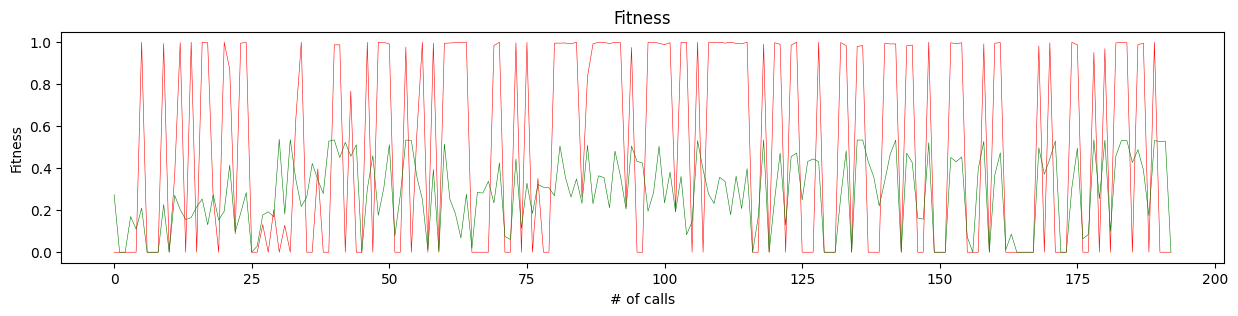

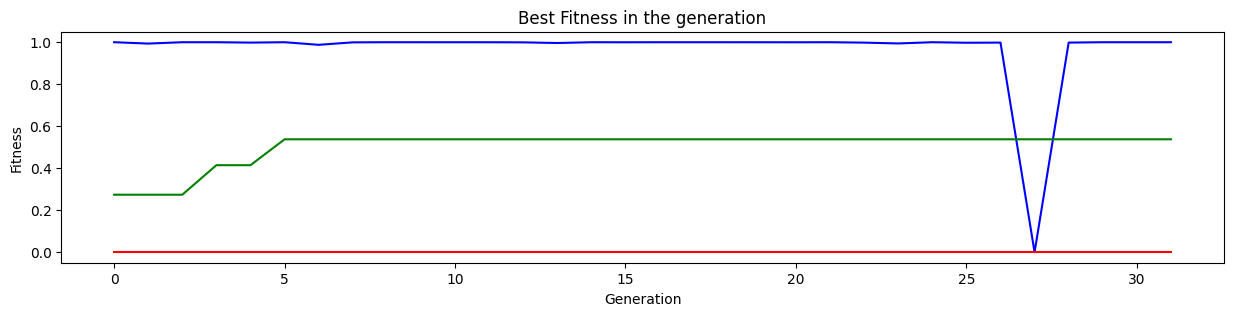

In [24]:
#read the values.csv
df = pd.read_csv('values_ga.csv')

# df = pd.read_csv('ga_0_01_negfitn.csv')
# df = pd.read_csv('ga_0_1_posfitness.csv')



plt.figure(figsize=(15,3))
plt.plot(df['fitnessEff'], 'r-', linewidth = 0.4)
plt.plot(df['fitnessSel'], 'g-', linewidth = 0.4)
plt.title('Fitness')
plt.xlabel('# of calls')
plt.ylabel('Fitness')
plt.show()


#save the best fitness in the generation and also the parameters for the best fitness
best_params = []
best_generat = []
best_sel = []
best_fake = []

pop_fit = []
pop_fit_sel = []
pop_fit_fake = []

j = 0
for i in range(len(df['fitnessEff'])):
    j = j + 1
    pop_fit.append(df['fitnessEff'][i])
    pop_fit_sel.append(df['fitnessSel'][i])
    pop_fit_fake.append(df['fitnessFake'][i])
    best_params.append(df.iloc[i, 0:12])

    if j == population_size:
        best_generat.append(np.max(pop_fit))
        best_sel.append(np.max(pop_fit_sel))
        best_fake.append(np.min(pop_fit_fake))
        j = 0
        pop_fit = []

#plot the best fitness in the generation
plt.figure(figsize=(15,3))
plt.plot(best_generat, 'b-')
plt.plot(best_sel, 'g-')
plt.plot(best_fake, 'r-')
plt.title('Best Fitness in the generation')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()




In [23]:
#find the best fitness and the corresponding paraemters
best_fitness = df['fitnessEff'].max()
best_parameters = df[df['fitnessEff'] == best_fitness]
best_parameters


,tau_m,tau_s,tau_r,tau_plus,tau_minus,a_plus,a_minus,CFI0,CF01,CFI1,alpha,TH0,TH1,fitnessEff,fitnessFake,fitnessSel
5,9.102248e-09,2.332218e-09,5.625149e-09,2.750222e-09,1.721533e-10,0.000068,0.000047,0.783027,0.672426,0.772701,0.293469,0.774965,0.895014,0.998208,9.999990e-07,0.209564
16,9.102248e-09,2.332218e-09,5.625149e-09,2.750222e-09,1.721533e-10,0.000007,0.000047,0.783027,0.672426,0.772701,0.293469,0.774965,0.895014,0.998208,9.999990e-07,0.253061
20,9.102248e-09,2.332218e-09,5.625149e-09,2.750222e-09,1.721533e-10,0.000068,0.000001,0.783027,0.672426,0.772701,0.293469,0.774965,0.895014,0.998208,9.999990e-07,0.194958
48,9.469853e-09,5.716599e-09,3.246150e-09,3.340029e-09,3.206706e-09,0.000076,0.000045,0.560381,0.462297,0.754805,0.473063,0.795468,0.600000,0.998208,9.999990e-07,0.175351
88,9.469853e-09,5.716599e-09,3.246150e-09,3.340029e-09,1.000000e-10,0.000076,0.000001,0.400000,0.462297,0.400000,0.100000,0.795468,0.895014,0.998208,9.999990e-07,0.363236
106,9.469853e-09,5.716599e-09,1.000000e-10,3.340029e-09,1.000000e-10,0.000042,0.000001,0.400000,0.462297,0.400000,0.413366,0.600000,0.667679,0.998208,9.999990e-07,0.530381
183,9.469853e-09,5.716599e-09,1.000000e-10,1.000000e-10,1.000000e-10,0.000007,0.000001,0.400000,0.400000,0.400000,0.360285,0.600000,0.600000,0.998208,9.999990e-07,0.530441


In [ ]:
# !../SNNT13.out --N_ev 2000 --tau_m 1.21e-9 --tau_s 7.70e-10 --tau_plus 6.28e-9 --tau_minus 7.19e-9 --a_plus 0.000109 --a_minus 0.000126 --CFI0 0.55 --CF01 0.56 --CFI1 0.66 --alpha 0.66 --TH0 0.86 --TH1 0.45



                                 ------------------------------------

                                    S   N   N      T r a c k i n g

                                 ------------------------------------




         ------------------------------------------------------------------------------------    
         Unsupervised search for tracks in 8-layer strip detector with spiking neural network    
                                                                             T.Dorigo, 3/2023    
         ------------------------------------------------------------------------------------    

         Run parameters: 
         -----------------------------------
                       L0 neurons: 6
                       L1 neurons: 6
            Connected L0-L1 frac.: 0.56
            Connected IN-L0 frac.: 0.55
            Connected IN-L1 frac.: 0.66
                    Track classes: 6
                     Total events: 2000
               Optimization loops: 1
             

Python(73831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In file included from input_line_3:38:
In file included from /Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/c++/v1/cassert:19:
In file included from /Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/c++/v1/__assert:14:
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/c++/v1/__verbose_abort:24:18: error: unknown type name '_LIBCPP_AVAILABILITY_VERBOSE_ABORT'
_LIBCPP_NORETURN _LIBCPP_AVAILABILITY_VERBOSE_ABORT _LIBCPP_OVERRIDABLE_FUNC_VIS _LIBCPP_ATTRIBUTE_FORMAT(__printf__, 1, 2)
                 ^
         -----------------------------------

         Starting values of parameters:
         -----------------------------------
                     L0 threshold: 0.86
                     L1 threshold: 0.45
                            alpha: 0.66
                        L1inhibit: 1
                                K:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generation = 1
Fitness    = 0.9334777399154944
Change     = 0.9334777399154944
Generation = 2
Fitness    = 2.0279266829969145
Change     = 1.09444894308142
Generation = 3
Fitness    = 2.0279266829969145
Change     = 0.0
Generation = 4
Fitness    = 5.316476732839327
Change     = 3.2885500498424123
Generation = 5
Fitness    = 17.241885618222277
Change     = 11.92540888538295
Generation = 6
Fitness    = 17.241885618222277
Change     = 0.0
Generation = 7
Fitness    = 17.241885618222277
Change     = 0.0
Generation = 8
Fitness    = 17.241885618222277
Change     = 0.0
Generation = 9
Fitness    = 17.241885618222277
Change     = 0.0
Generation = 10
Fitness    = 17.241885618222277
Change     = 0.0
Generation = 11
Fitness    = 17.241885618222277
Change     = 0.0
Generation = 12
Fitness    = 25.695790011075722
Change     = 8.453904392853445
Generation = 13
Fitness    = 25.695790011075722
Change     = 0.0
Generation = 14
Fitness    = 25.695790011075722
Change     = 0.0
Generation = 15
Fitness    = 

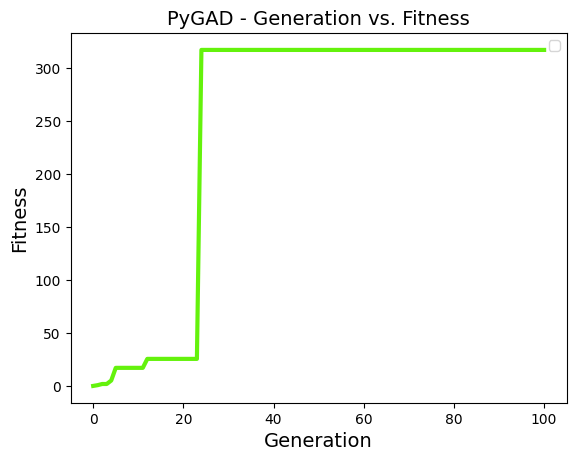

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [-0.89222445 -1.60808393  3.15377966  1.19700327 -2.70719649  0.52187904]
Fitness value of the best solution = 316.87567965264014
Index of the best solution : 0
Predicted output based on the best solution : 43.99684518822834
Best fitness value reached after 24 generations.


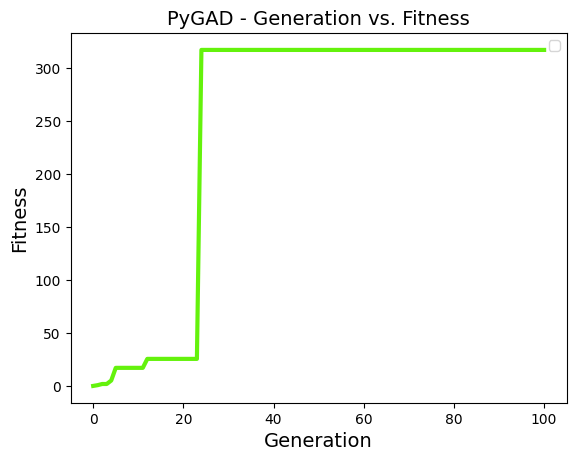

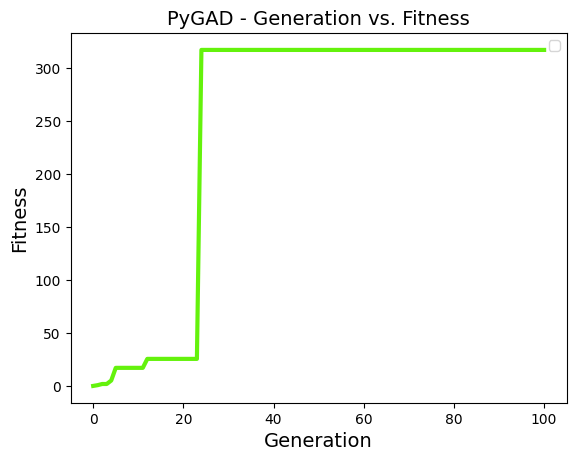

In [ ]:
import pygad
import numpy

"""
Given the following function:
    y = f(w1:w6) = w1x1 + w2x2 + w3x3 + w4x4 + w5x5 + 6wx6
    where (x1,x2,x3,x4,x5,x6)=(4,-2,3.5,5,-11,-4.7) and y=44
What are the best values for the 6 weights (w1 to w6)? We are going to use the genetic algorithm to optimize this function.
"""

function_inputs = [4,-2,3.5,5,-11,-4.7] # Function inputs.
desired_output = 44 # Function output.

def fitness_func(ga_instance, solution, solution_idx):
    output = numpy.sum(solution*function_inputs)
    fitness = 1.0 / (numpy.abs(output - desired_output) + 0.000001)
    return fitness

num_generations = 100 # Number of generations.
num_parents_mating = 10 # Number of solutions to be selected as parents in the mating pool.

sol_per_pop = 20 # Number of solutions in the population.
num_genes = len(function_inputs)

last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    print(f"Change     = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness}")
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       on_generation=on_generation)

# Running the GA to optimize the parameters of the function.
ga_instance.run()

ga_instance.plot_fitness()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

prediction = numpy.sum(numpy.array(function_inputs)*solution)
print(f"Predicted output based on the best solution : {prediction}")

if ga_instance.best_solution_generation != -1:
    print(f"Best fitness value reached after {ga_instance.best_solution_generation} generations.")

# Saving the GA instance.
filename = 'genetic' # The filename to which the instance is saved. The name is without extension.
ga_instance.save(filename=filename)

# Loading the saved GA instance.
loaded_ga_instance = pygad.load(filename=filename)
loaded_ga_instance.plot_fitness()